# Q-Learning and Expected Sarsa Trading Strategy Search

In [1]:
# %load_ext iminizinc
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
import pandas_ta as ta
from math import *
from collections import OrderedDict
import json
from decimal import *
getcontext().prec = 6
import seaborn as sns
from scipy.signal import find_peaks, peak_widths
import pickle



%matplotlib inline


# mpl.rcParams.update({'font.size': 10, 'lines.linewidth': 0.5, 'figure.dpi': 600})
plt.rcParams['lines.linewidth'] = 0.5 
plt.rcParams.update({'font.size': 6})
plt.rcParams.update({'figure.figsize': [15,5]})


In [2]:


from tqdm import tqdm
from scipy.stats import sem


# sys.path.append(os.path.abspath('.'))
from lib.rl_glue import RLGlue
from lib.TradeEnvironment import TradeEnvironment
from lib.QLearningAgent import QLearningAgent
from lib.ExpectedSarsaAgent import ExpectedSarsaAgent
from lib.utils import load_candles, flatten_past_n

# from rl_glue import RLGlue
# from agent import BaseAgent
# import cliffworld_env

In [3]:
TradeEnvironment

lib.TradeEnvironment.TradeEnvironment

In [4]:
wstart = 8000
wlen = 100
wdf = odf[['cudir', 'cudir_L4', 'cudir_L3', 'cudir_L2', 'cudir_L1', 'cdir']].iloc[wstart:wstart+wlen, :]
wdf.columns

NameError: name 'odf' is not defined

In [5]:
odf.cudir.clip(-5,5)

NameError: name 'odf' is not defined

# Prepare the dataset

In [6]:
pair = 'BTC_USDT'
timeframe = '1h'

exchange = 'binance'
odf = load_candles(exchange=exchange, pair=pair, timeframe=timeframe)

odf['cdir'] = -1 + 2 *(odf.close > odf.open)
odf['grflip'] = (odf.cdir != odf.cdir.shift()).fillna(0).cumsum()
odf['cudir'] = odf[['cdir', 'grflip']].groupby('grflip')[['cdir']].cumsum().clip(-5,5)
# odf['ncudir'] = odf.cudir.add(5).subtract(odf.cudir > 0)
odf


,timestamp,open,high,low,close,volume,cdir,grflip,cudir
dtime,,,,,,,,,
2017-08-17 04:00:00,1502942400000,4261.48,4313.62,4261.32,4308.83,47.181009,1,1,1
2017-08-17 05:00:00,1502946000000,4308.83,4328.69,4291.37,4315.32,23.234916,1,1,2
2017-08-17 06:00:00,1502949600000,4330.29,4345.45,4309.37,4324.35,7.229691,-1,2,-1
2017-08-17 07:00:00,1502953200000,4316.62,4349.99,4287.41,4349.99,4.443249,1,3,1
2017-08-17 08:00:00,1502956800000,4333.32,4377.85,4333.32,4360.69,0.972807,1,3,2
...,...,...,...,...,...,...,...,...,...
2023-07-16 19:00:00,1689534000000,30276.87,30298.71,30200.43,30252.93,632.928300,-1,27916,-2
2023-07-16 20:00:00,1689537600000,30252.94,30296.84,30236.00,30271.64,390.372500,1,27917,1
2023-07-16 21:00:00,1689541200000,30271.64,30314.48,30271.64,30292.65,302.906520,1,27917,2


# Feature states and rewards

In [7]:
# odf.head(1000).cudir.unique()

In [8]:
# odf = odf.head(1000)
num_lags = 4
# odf = odf.join(flatten_past_n(odf[['ncudir']], num_lags).astype(int)).dropna()
# odf['cudir_L1'] = odf['cudir'].shift().fillna(0).astype(int)
features = ['cudir']

cat_features = odf[features].astype('category')
cat_feature_codes = cat_features.apply(lambda x: x.cat.codes)
cat_feature_counts = cat_features.dtypes.apply(lambda x: x.categories.shape[0])
cat_feature_counts


cudir    10
dtype: int64

In [9]:
# cat_feature_codes.cudir.unique()

In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

state_features_specs = [('cudir', 1), ('cudir', 3), ('cudir', 5), ('cudir',7)]

# lagged_feature_codes = pd.concat({
#     k:v
#     for i, (feature, lag) in enumerate(lagged_features_specs)
#     for k in [f'{i}__{feature}_LAG_{lag}']
#     for v in [cat_feature_codes[feature].shift(lag)]
# }, axis=1).dropna().astype(int)#.values

# lagged_feature_codes.agg(lambda x:  print(x.values), axis=1)

state_features = pd.concat({
    k:v
    for i, (feature, lag) in enumerate(state_features_specs)
    for k in [f'{feature}_LAG_{lag}']
    for v in [cat_features[feature].shift(lag)]
}, axis=1).dropna().astype(int)#.values


state_features['feat_cat'] = state_features.agg(lambda x:  np.array2string(x.values, separator=',', formatter={'int_kind': lambda x: "{:>+}".format(x)}), axis=1)

le.fit(state_features['feat_cat'])
state_features['state_no'] = le.transform(state_features['feat_cat'].values).astype(int)
state_features
odf = odf.join(state_features).dropna()
# odf

In [11]:
# state_features
odf

,timestamp,open,high,low,close,volume,cdir,grflip,cudir,cudir_LAG_1,cudir_LAG_3,cudir_LAG_5,cudir_LAG_7,feat_cat,state_no
dtime,,,,,,,,,,,,,,,
2017-08-17 11:00:00,1502967600000,4460.00,4485.39,4427.30,4427.30,27.018053,-1,4,-1,4.0,2.0,-1.0,1.0,"[+4,+2,-1,+1]",280.0
2017-08-17 12:00:00,1502971200000,4436.06,4449.56,4411.00,4411.00,23.032398,-1,4,-2,-1.0,3.0,1.0,2.0,"[-1,+3,+1,+2]",381.0
2017-08-17 13:00:00,1502974800000,4411.00,4459.00,4411.00,4459.00,31.312436,1,5,1,-2.0,4.0,2.0,-1.0,"[-2,+4,+2,-1]",550.0
2017-08-17 14:00:00,1502978400000,4459.00,4485.39,4435.93,4470.82,51.735897,1,5,2,1.0,-1.0,3.0,1.0,"[+1,-1,+3,+1]",95.0
2017-08-17 15:00:00,1502982000000,4470.82,4470.82,4333.42,4352.34,68.481270,-1,6,-1,2.0,-2.0,4.0,2.0,"[+2,-2,+4,+2]",216.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-16 19:00:00,1689534000000,30276.87,30298.71,30200.43,30252.93,632.928300,-1,27916,-2,-1.0,-2.0,2.0,-1.0,"[-1,-2,+2,-1]",450.0
2023-07-16 20:00:00,1689537600000,30252.94,30296.84,30236.00,30271.64,390.372500,1,27917,1,-2.0,1.0,-1.0,1.0,"[-2,+1,-1,+1]",500.0
2023-07-16 21:00:00,1689541200000,30271.64,30314.48,30271.64,30292.65,302.906520,1,27917,2,1.0,-1.0,-2.0,2.0,"[+1,-1,-2,+2]",111.0


In [12]:

test_ratio = 0.5

n_test = int(odf.shape[0] * (1.-test_ratio))

df_train = odf.iloc[:n_test-1, :]
df_test = odf.iloc[n_test:,:]

df_train.shape, df_test.shape

((25849, 15), (25851, 15))

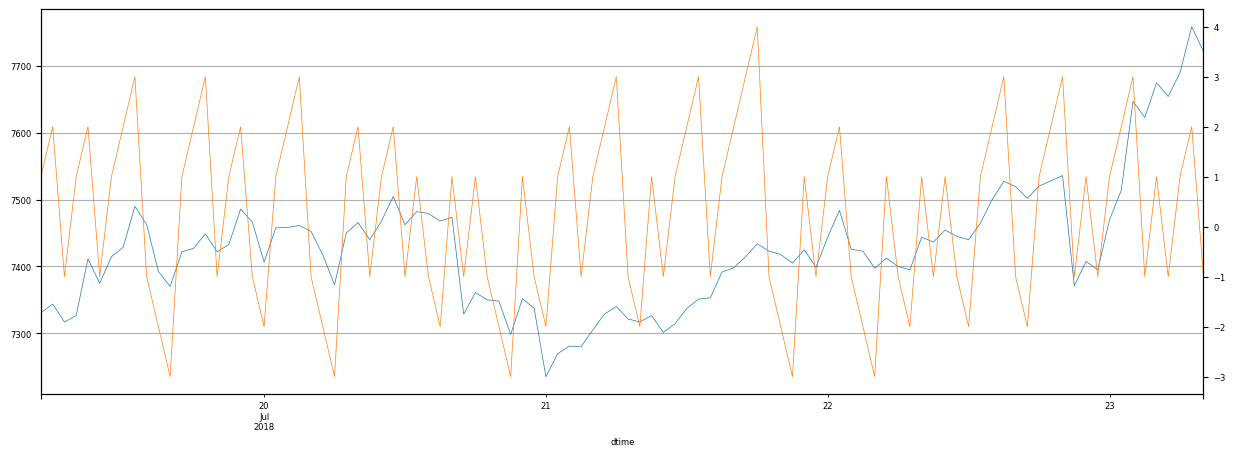

In [13]:
wstart = 8000
wlen = 100
wdf = odf.iloc[wstart:wstart+wlen, :]
# fig, ax1 = plt.subplots(1,1, figsize=(15,5), height_ratios=(2,1), sharex=True)
ax1 = wdf.close.plot(figsize=(15,5))
wdf.cudir.plot(ax=ax1, secondary_y=True)
# tax1 = ax1.twinx()
# ax2.step(x=wdf.index.values, y=wdf.cudir.values, c='orange', lw=1)
# ax2.plot(wdf.cudir.values)
ax1.grid()

In [14]:
odf.cudir.add(5).subtract(odf.cudir > 0).unique()

array([4, 3, 5, 6, 2, 7, 1, 8, 9, 0])

# Solving the Trading Strategy

Using the experiment program in the cell below we now compare the agents on the Cliff World environment and plot the sum of rewards during each episode for the two agents.

The result of this cell will be graded. If you make any changes to your algorithms, you have to run this cell again before submitting the assignment.

In [15]:
# wstart = 9000
# wlen = 6 * 3 #7 * 2
# wnum = odf.shape[0] // wlen
# wdf = odf.iloc[wstart:wstart+wlen, :]
# obs_states = wdf[['ncudir_L4', 'ncudir_L3', 'ncudir_L2', 'ncudir_L1']].astype(int)
# hidden_states = wdf[['cdir']]

In [16]:

# num_episodes = 10 # The number of episodes in each run

def get_episodes(odf, wlen, size ):
# wlen = 6 * 3 #7 * 2
    wnum = odf.shape[0] // wlen
    nepisodes = 20
    episode_starts = np.random.randint(wnum, size=size).tolist()
    episodes = [
        odf.iloc[start:start + wlen]
        for start in episode_starts
    ]
    return episodes
# obs_states

In [19]:
# ---------------
# Discussion Cell
# ---------------
%autoreload 2
np.random.seed(0)

agents = {
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}
num_actions = 3
num_states = le.classes_.shape[0]
env = TradeEnvironment
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
agent_info = {"num_actions": num_actions, "num_states": num_states , "is_training__": True, "epsilon": 0.1, "step_size": 0.5, "discount": 1.0}
env_info = {
    # 'obs_states': obs_states,
    # 'hidden_states':  hidden_states
}
num_runs = 10 # The number of runs
num_episodes = 50 # The number of episodes in each run


for algorithm in ["Q-learning", "Expected Sarsa"]:
    all_reward_sums[algorithm] = []
    all_state_visits[algorithm] = []
    for run in tqdm(range(num_runs)):
        
        df_episodes = get_episodes(df_train, 24 * 3 , size=num_episodes)

        agent_info["seed"] = run
        rl_glue = RLGlue(env, agents[algorithm])
        rl_glue.rl_init(agent_info, {**env_info})

        reward_sums = []
        state_visits = np.zeros(num_states)
        for episode in range(num_episodes):
            wdf = df_episodes[episode]
            obs_states = wdf.state_no.astype(int)
            hidden_states = wdf
            env_start_info={'obs_states': obs_states, 'hidden_states': hidden_states}


            if episode < num_episodes - 10:
                # Runs an episode
                rl_glue.rl_episode(10000, env_start_info=env_start_info) 
            else: 
                # Runs an episode while keeping track of visited states
                state, action = rl_glue.rl_start(env_start_info=env_start_info)
                # print('state, action:', state, action)
                state_visits[state] += 1
                is_terminal = False
                while not is_terminal:
                    reward, state, action, is_terminal = rl_glue.rl_step()
                    # print('reward, state, action, is_terminal:', reward, state, action, is_terminal)
                    state_visits[state] += 1
                
            reward_sums.append(rl_glue.rl_return())
            
        all_reward_sums[algorithm].append(reward_sums)
        all_state_visits[algorithm].append(state_visits)

# plot results
for algorithm in ["Q-learning", "Expected Sarsa"]:
    plt.plot(np.mean(all_reward_sums[algorithm], axis=0), label=algorithm)
plt.xlabel("Episodes")
plt.ylabel("Episode log returns",rotation=0, labelpad=40)
# plt.ylim(-20,20)
plt.legend()
plt.grid()
plt.show()

TypeError: super(type, obj): obj must be an instance or subtype of type

To see why these two agents behave differently, let's inspect the states they visit most. Run the cell below to generate plots showing the number of timesteps that the agents spent in each state over the last 10 episodes.

In [30]:
qagent = agents['Q-learning']
print(qagent.get_q())

TypeError: SampleBaseAgent.get_q() missing 1 required positional argument: 'self'

ValueError: cannot reshape array of size 640 into shape (4,12)

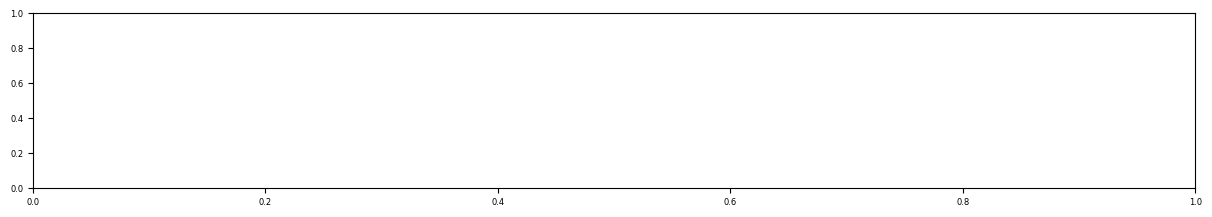

In [18]:
# ---------------
# Discussion Cell
# ---------------

for algorithm, position in [("Q-learning", 211), ("Expected Sarsa", 212)]:
    plt.subplot(position)
    average_state_visits = np.array(all_state_visits[algorithm]).mean(axis=0)
    grid_state_visits = average_state_visits.reshape((4,12))
    grid_state_visits[0,1:-1] = np.nan
    plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=2)
    plt.title(algorithm)
    plt.axis('off')
    cm = plt.get_cmap()
    cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
    cax = plt.axes([0.85, 0.0, 0.075, 1.])
    
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel("Visits during\n the last 10\n episodes", rotation=0, labelpad=70)
plt.show()

The Q-learning agent learns the optimal policy, one that moves along the cliff and reaches the goal in as few steps as possible. However, since the agent does not follow the optimal policy and uses $\epsilon$-greedy exploration, it occasionally falls off the cliff. The Expected Sarsa agent takes exploration into account and follows a safer path.


Previously we used a fixed step-size of 0.5 for the agents. What happens with other step-sizes? Does this difference in performance persist?

In the next experiment we will try 10 different step-sizes from 0.1 to 1.0 and compare the sum of rewards per episode averaged over the first 100 episodes (similar to the interim performance curves in Figure 6.3 of the textbook). Shaded regions show standard errors.

This cell takes around 10 minutes to run. The result of this cell will be graded. If you make any changes to your algorithms, you have to run this cell again before submitting the assignment.

100%|██████████| 600/600 [02:14<00:00,  4.45it/s]


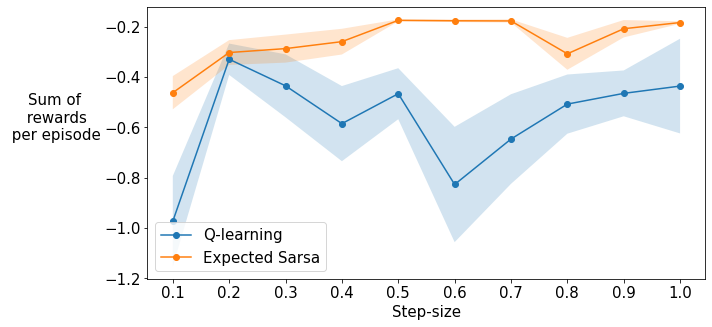

In [15]:
# ---------------
# Discussion Cell
# ---------------
from itertools import product

agents = {
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}
env = cliffworld_env.Environment
all_reward_sums = {}
step_sizes = np.linspace(0.1,1.0,10)
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "discount": 1.0}
env_info = {}
num_runs = 30
num_episodes = 100
all_reward_sums = {}

algorithms = ["Q-learning", "Expected Sarsa"]
cross_product = list(product(algorithms, step_sizes, range(num_runs)))
for algorithm, step_size, run in tqdm(cross_product):
    if (algorithm, step_size) not in all_reward_sums:
        all_reward_sums[(algorithm, step_size)] = []

    agent_info["step_size"] = step_size
    agent_info["seed"] = run
    rl_glue = RLGlue(env, agents[algorithm])
    rl_glue.rl_init(agent_info, env_info)

    last_episode_total_reward = 0
    for episode in range(num_episodes):
        rl_glue.rl_episode(0)
    all_reward_sums[(algorithm, step_size)].append(rl_glue.rl_return()/num_episodes)
        

for algorithm in ["Q-learning", "Expected Sarsa"]:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    algorithm_stds = np.array([sem(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(step_sizes)
plt.show()

Expected Sarsa shows an advantage over Q-learning in this problem across a wide range of step-sizes.

Congratulations! Now you have:

- implemented Q-Learning with $\epsilon$-greedy action selection
- implemented Expected Sarsa with $\epsilon$-greedy action selection
- investigated the behavior of these two algorithms on Cliff World